Avviare l'env:<br>
cd .env<br>
source bin/activate

Disattivarlo:
deactivate

-------------------------------------
L'euristica shortest path funziona in questo modo:
- crea un albero con il primo nodo di steiner
- finchè ci sono nodi di steiner:<br>
    -> determina quale nodo è più vicino all'albero<br>
    -> aggiungi questo nodo tramite shortest path<br>
    

In [42]:
import os
import heapq
import pandas as pd
import time
from functions import *
import sys

In [43]:
#DIJKSTRA:CALCOLO DELLE DISTANZE - Grafo di partenza su cui calcolare le distanze, nodo di partenza, nodi rispetto a cui mi interessa calcolare la distanza
#COSTO COMPUTAZIONALE: O(|E| + |V| * log(|V|)) nel caso peggiore
#Uso come struttura dati una miniheap (modulo heapq)
def dijkstra(graph, start, steiner_tree):
    distances = {node: float('inf') for node in graph.get_vertices()}  # Initialize distances to infinity
    distances[start] = 0  # Distance from start node to itself is 0
    priority_queue = [(0, start)]  # Use a priority queue to prioritize nodes with shorter distances
    visited = set()  # Set to track visited nodes
    found_nodes = set()  # Set to track found target nodes
    
    while priority_queue and found_nodes != set(steiner_tree.get_vertices()):
        current_distance, current_node = heapq.heappop(priority_queue)  # Get the node with the smallest distance
        
        # Skip if we have already found a shorter path to the current node
        if current_distance > distances[current_node]:
            continue
        
        visited.add(current_node)  # Mark current node as visited
        
        # Check if the current node is a target node
        if current_node in steiner_tree.get_vertices():
            found_nodes.add(current_node)
        
        #Explore neighbors of the current node
        neighbors = graph.get_neighbors(current_node)
        for neighbor, weight in neighbors.items():
            if neighbor in visited:
                continue  # Skip already visited neighbors
            distance = current_distance + weight
            if distance < distances[neighbor]:  # If a shorter path is found, update the distance
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))  # Add the neighbor to the priority queue
    result_distances = {}
    for i in distances:
        if i in steiner_tree.get_vertices():
            result_distances[i] = distances[i]
        
    
    return result_distances

In [44]:
#EURISTICA SHORTEST PATH
def shortest_path(grafo):
    start_time = time.time()
    steiner_tree = Graph()
    terminals = (grafo.get_steiner_vertices()).copy()
    
    #Estraggo il primo dei terminali e lo inserisco nel risultato
    first_node = terminals.pop(0)
    steiner_tree.add_vertex(first_node)
    steiner_tree.add_steiner(first_node)
    
    #Finchè ho dei nodi terminali da inserire nell'albero
    while len(terminals) > 0:
        #1) Trovo il nodo di steiner che ha la distanza minore dallo steiner tree attuale 
        # (Controllo Djikstra da ogni nodo terminal rispetto a tutti i nodi (dello steiner tree))
        terminals_distances = {}
        i = 0 
        #Controllo con dijkstra tutte le distanze
        for i in range(0, len(terminals)):
            result_dijkstra = dijkstra(grafo, terminals[i], steiner_tree)
            #Trovo il nodo con cui il terminale ha la distanza minima
            minimum_key, minimum_distance = min(result_dijkstra.items(), key=lambda x: x[1])
            terminals_distances[terminals[i]] = {minimum_key : minimum_distance}
        
        #Trovo quale terminale è più vicino all'albero
        minimum_value = min(terminals_distances.values(), key=lambda x: next(iter(x.values())))
        minimum_node = []
        for key, val in terminals_distances.items():
            if val == minimum_value:
                minimum_node.append(key)
        #Nodo a distanza minima, distanza dal nodo, terminals da attaccare
        nodo_di_attacco = list(minimum_value.items())[0][0]
        distanza_di_attacco = list(minimum_value.items())[0][1]
        nodo_terminal_da_aggiungere = minimum_node[0]
        
        #2) Attacco il nodo - Trovo il shortest path tra i il terminal e il nodo più vicino dell'albero
        path = grafo.find_shortest_path(nodo_di_attacco,nodo_terminal_da_aggiungere)
        #Aggiungo il percorso al grafo di steiner
        for edge in path:
            steiner_tree.add_edge(edge[0],edge[1],path[edge])
            
        #Rimuovo dalla lista il terminale aggiunto
        terminals.remove(nodo_terminal_da_aggiungere)
        steiner_tree.add_steiner(nodo_terminal_da_aggiungere)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    #Controllo ammissibilità:
    if not(check_admissibility(grafo, steiner_tree)):
        print("NON è STATO PASSATO IL CONTROLLO DELL'AMMISSIBILITà")
        sys.exit(0)
        
    
    return steiner_tree, execution_time
    

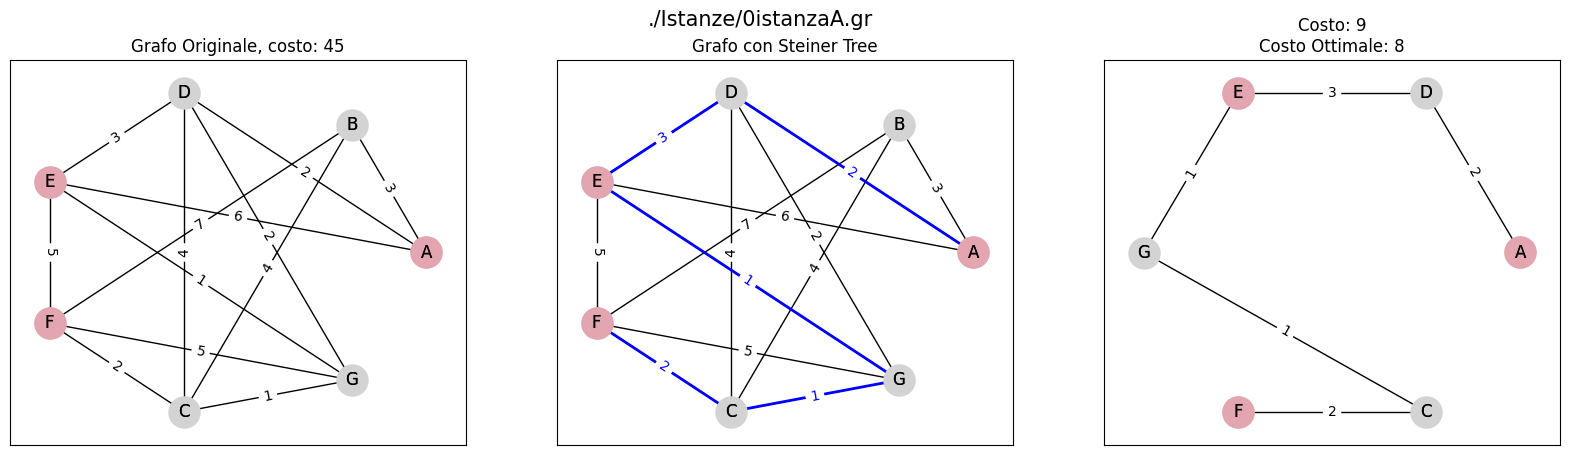

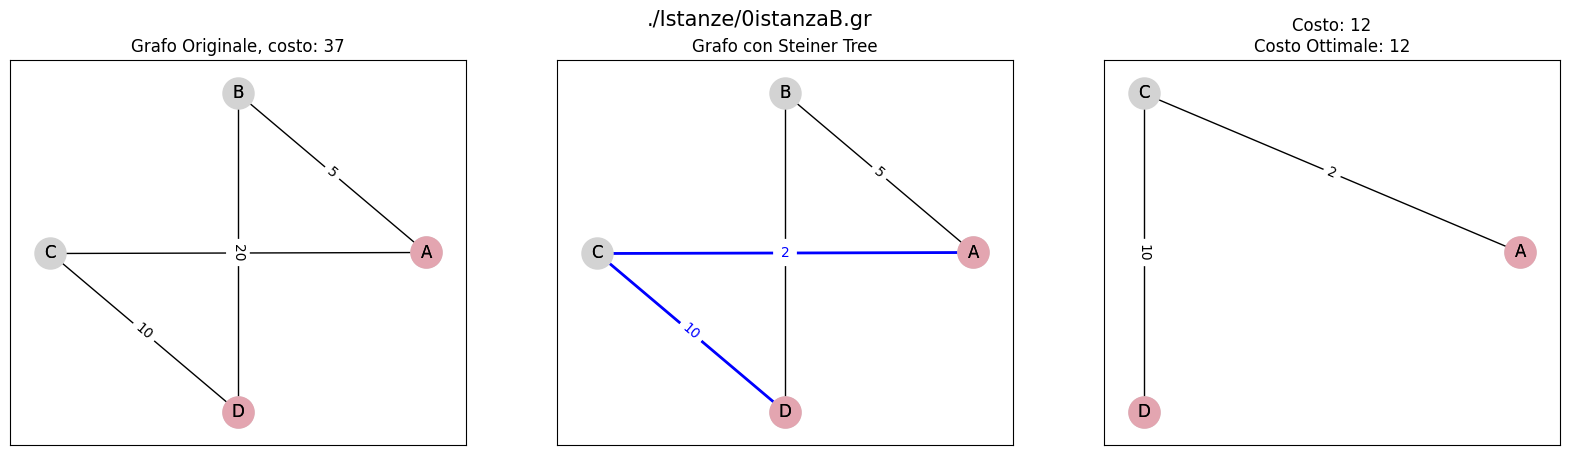

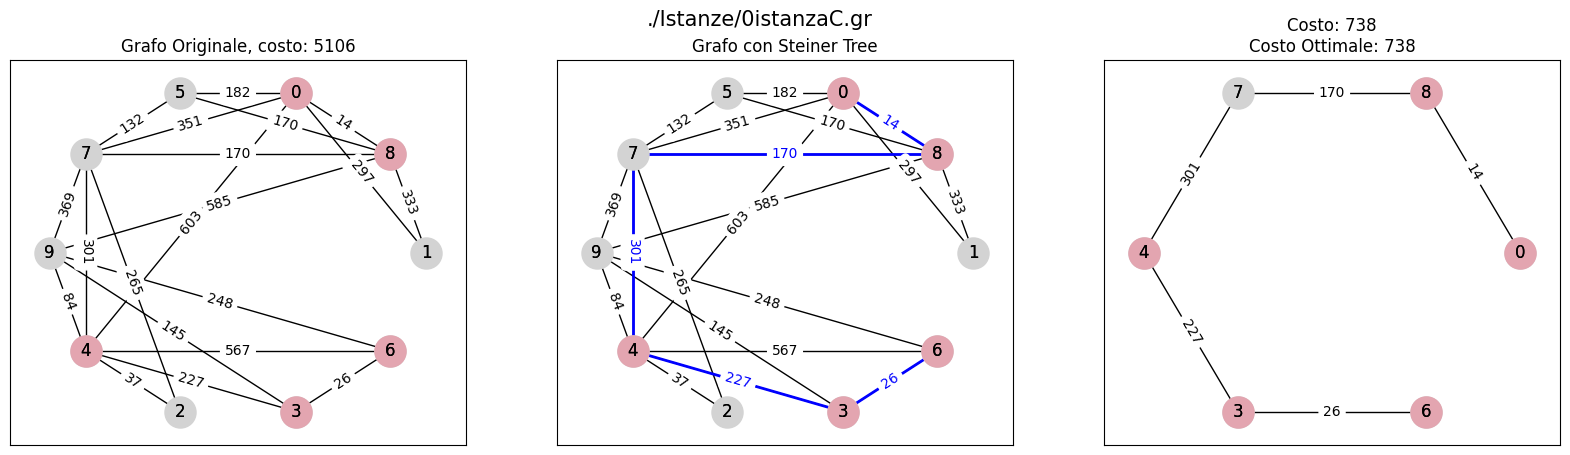

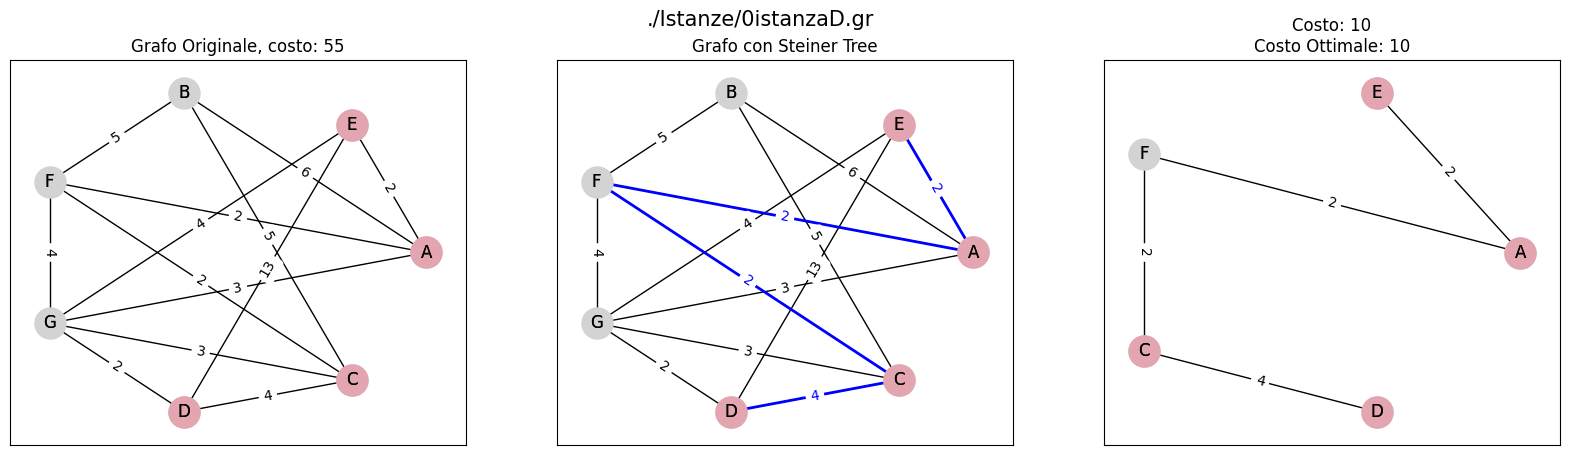

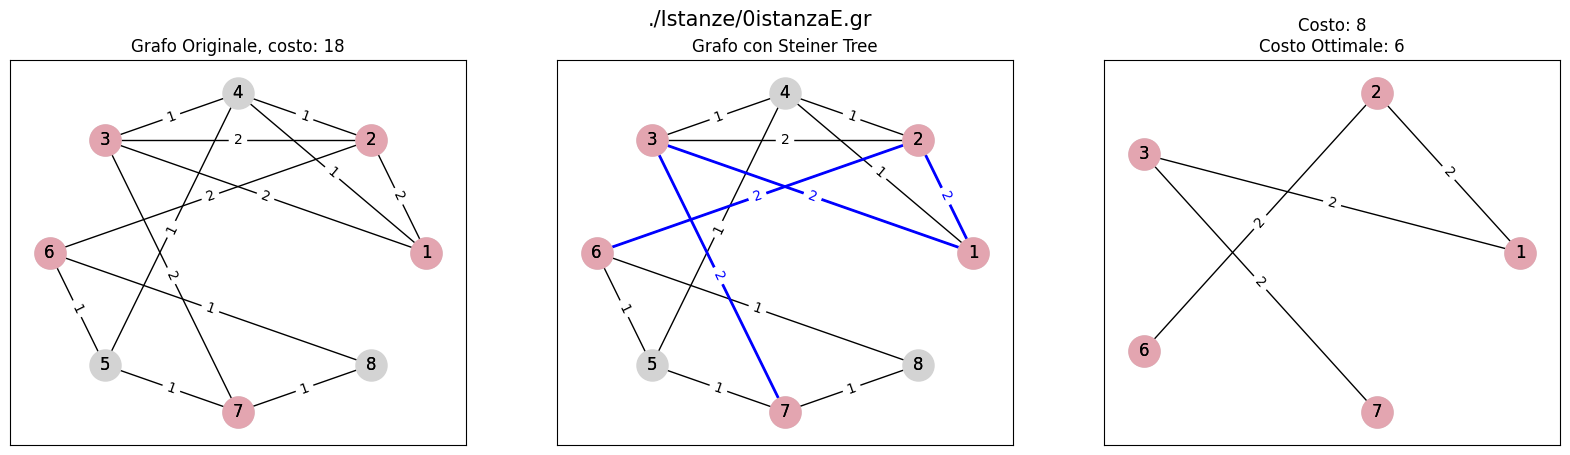

In [45]:
#PROVE DEI RISULTATI OTTENUTI applicando l'euristica1: shortest path

#Lettura delle istanze da file ed esecuzione
file_path = "./Istanze/0istanzaA.gr" 
grafo = create_graph(file_path)
steiner_tree, timeS = shortest_path(grafo)
draw_row_graph(file_path,grafo,steiner_tree)


file_path = "./Istanze/0istanzaB.gr" 
grafo1 = create_graph(file_path)
steiner_tree1, timeS = shortest_path(grafo1)
draw_row_graph(file_path,grafo1,steiner_tree1)

file_path = "./Istanze/0istanzaC.gr" 
grafo2 = create_graph(file_path)
steiner_tree2, timeS = shortest_path(grafo2)
draw_row_graph(file_path,grafo2,steiner_tree2)

file_path = "./Istanze/0istanzaD.gr" 
grafo3 = create_graph(file_path)
steiner_tree3, timeS = shortest_path(grafo3)
draw_row_graph(file_path,grafo3,steiner_tree3)

file_path = "./Istanze/0istanzaE.gr" 
grafoE = create_graph(file_path)
steiner_treeE, timeS = shortest_path(grafoE)
draw_row_graph(file_path,grafoE,steiner_treeE)



In [46]:
#Valutazione su tutte le istanze presenti
data = {
    'Nome': [],
    'Num_Vertici': [],
    'Num_Terminals': [],
    'Num_Archi': [],
    'Num_Vertici_Steiner': [],
    'Num_Archi_Steiner': [],
    'Costo_Steiner':[],
    'Costo_Ottimale':[],
    'Differenza_ottimo':[],
    'Time(s)':[],
}

directory = './Istanze/'

# Iterate over all files in the directory
for filename in sorted(os.listdir(directory)):
    #Prendo i nomi dei file
    file_path = os.path.join(directory, filename)
    #print(file_path)
    #Calcolo i valori
    grafo = create_graph(file_path)
    steiner_tree, timeS = shortest_path(grafo)
    
    #Aggiungo i risultati
    data['Nome'].append(filename.split('.')[0])
    data['Num_Vertici'].append(grafo.get_num_vertices())
    data['Num_Terminals'].append(grafo.get_num_vertices_steiner())
    data['Num_Archi'].append(grafo.get_num_edges())
    data['Num_Vertici_Steiner'].append(steiner_tree.get_num_vertices())
    data['Num_Archi_Steiner'].append(steiner_tree.get_num_edges())
    costo_albero_minimo = steiner_tree.calculate_cost()
    ottimo = grafo.get_optimal_cost_steiner_tree()
    difference = int(costo_albero_minimo) - int(ottimo)
    data['Costo_Steiner'].append(costo_albero_minimo)
    data['Costo_Ottimale'].append(ottimo)
    data['Differenza_ottimo'].append(difference)
    data['Time(s)'].append(timeS)
    

df = pd.DataFrame(data).set_index('Nome')
df = df.sort_index()
pd.set_option('display.max_columns', None)  # Imposta la larghezza massima delle colonne a None
pd.set_option('display.expand_frame_repr', False) 


# Print the table
print(df)

              Num_Vertici  Num_Terminals  Num_Archi  Num_Vertici_Steiner  Num_Archi_Steiner  Costo_Steiner Costo_Ottimale  Differenza_ottimo    Time(s)
Nome                                                                                                                                                   
0istanzaA               7              3         13                    6                  5              9              8                  1   0.000316
0istanzaB               4              2          4                    3                  2             12             12                  0   0.000156
0istanzaC              10              5         20                    6                  5            738            738                  0   0.000898
0istanzaD               7              4         13                    5                  4             10             10                  0   0.000399
0istanzaE               8              5         13                    5                

stampa best solution:  [('A', 'D'), ('E', 'D'), ('E', 'G'), ('D', 'E'), ('D', 'A'), ('F', 'C'), ('C', 'F'), ('C', 'G'), ('G', 'C'), ('G', 'E')]
stampa best solution cost:  ['A', 'E', 'D', 'F', 'C', 'G']
VERTICES:  {'A': {'D': 2}, 'E': {'D': 3, 'G': 1}, 'D': {'E': 3, 'A': 2}, 'F': {'C': 2}, 'C': {'F': 2, 'G': 1}, 'G': {'C': 1, 'E': 1}}
##############################################################
stampa removed edge:  ('E', 'D') E D
Archi della nuova soluzione: [('A', 'D'), ('E', 'G'), ('F', 'C'), ('C', 'G')]
Vertici della nuova soluzione: ['A', 'E', 'D', 'F', 'C', 'G']
VERTICES:  {'A': {'D': 2}, 'E': {'G': 1}, 'D': {'A': 2}, 'F': {'C': 2}, 'C': {'F': 2, 'G': 1}, 'G': {'C': 1, 'E': 1}}
Grafo1:  ['E', 'G', 'C', 'F']
Grafo2:  ['D', 'A']


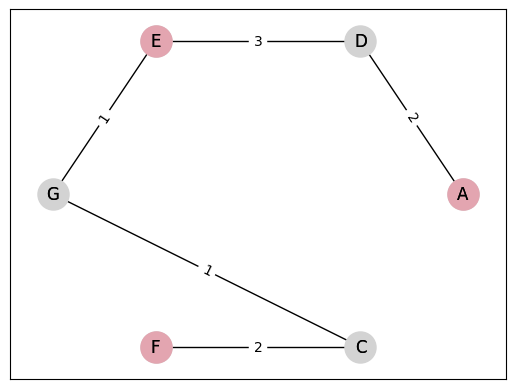

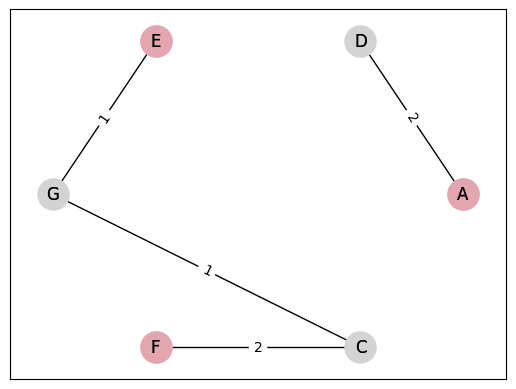

In [47]:
#Implementare ricerca locale: con first improvment
''' 
Input: soluzione ammissibile di partenza, costo soluzione di partenza
k = 1 (prima iterazione)
x* = x1

Esplorazione intorno:
- preparo una lista di tutti gli archi in soluzione
- Elimino un arco (pop)
- Elimino anche tutti i nodi non terminali e archi di grado 1
- Ricollego i due alberi che si sono formati tramite shortest path:
    > controllo per ogni possibile nodo dei due alberi quale ha il percorso minore e li collego
- Calcolo il costo  della nuova soluzione
    > se è migliore accetto la soluzione e itero sul nuovo intorno
    > se è uguale accetto solo se è diversa dalla precedente (controllo che gli archi siano diversi): ATTENZIONE POSSIBILE LOOP
    
Se ho esplorato tutto l'intorno ma non c'è una soluzione migliore:
> stop e restituisci x*
'''
import copy
def remove_duplicate(edges):
    #Rimuovo i duplicati dall'elenco degli archi
    edges_unique = []
    for tup in edges:
        if tup not in edges_unique and (tup[1],tup[0]) not in edges_unique:
            edges_unique.append(tup)
    return edges_unique

def local_search(original, solution, cost):
    k = 1 #numero di esplorazioni 
    best_solution = solution #migliore soluzione trovata fino a questo momento
    best_solution_cost = cost #costo della migliore soluzione trovata fino a questo momento
    fig = plt.figure()
    best_solution.draw_graph()
    print("stampa best solution: ", best_solution.get_edges())
    print("stampa best solution cost: ", best_solution.get_vertices())
    print("VERTICES: ", best_solution.vertices)
    print("##############################################################")
    all_edges = solution.get_edges()
    edges_unique = remove_duplicate(all_edges)
    
    #while True:
    #Se ho esplorato tutto l'intorno mi fermo e restituisco la soluzione migliore
    if (len(edges_unique) == 0):
        return best_solution, best_solution_cost
    
    #Prendo un arco dall'elenco degli archi
    removed_edge = edges_unique.pop(1) #FORSE è MEGLIO PROCEDERE CASUALMENTE INVECE DI MANTENERE L'ORDINE
    first_node_tree1 = removed_edge[0]
    first_node_tree2 = removed_edge[1]
    print("stampa removed edge: ", removed_edge, first_node_tree1, first_node_tree2)
    #rimuovo l'arco dalla soluzione
    new_solution = copy.deepcopy(best_solution) #deep copy dell'oggetto iniziale
    new_solution.remove_edge(removed_edge)
    '''result = True
    while (result):
        result = new_solution.remove_degree_one_nodes()'''
        
    new_solution_edges = remove_duplicate(new_solution.get_edges())
    print("Archi della nuova soluzione:", new_solution_edges)
    new_solution_vertices = new_solution.get_vertices()
    print("Vertici della nuova soluzione:", new_solution_vertices)
    fig = plt.figure()
    new_solution.draw_graph()
    nuovi_vertici =  new_solution.vertices
    print("VERTICES: ",nuovi_vertici)
    
    #Trovo i due insiemi di vertici creati dal taglio: partenza: E e D
    #[('A', 'D'), ('E', 'G'), ('F', 'C'), ('C', 'G')]
    #{'A': {'D': 2}, 'E': {'G': 1}, 'D': {'A': 2}, 'F': {'C': 2}, 'C': {'F': 2, 'G': 1}, 'G': {'C': 1, 'E': 1}}
    grafo1 = []
    grafo2 = []
    grafo1.append(first_node_tree1) #Poi devi considerare cosa succede quando rimuovo nodi di grado 1 (o forse posso farlo anche dopo questo passaggio)
    grafo2.append(first_node_tree2)
    
    #Inserisco quali nodi sono del sottoalbero 1 e quali del sottoalbero2
    while len(new_solution_edges) > 0:
        for el in new_solution_edges:
            found = False
            if el[0] in grafo1 and el[1] not in grafo1:
                grafo1.append(el[1])
                found = True
                
            if el[1] in grafo1 and el[0] not in grafo1:
                grafo1.append(el[0])
                found = True
            
            if el[0] in grafo2 and el[1] not in grafo2:
                grafo2.append(el[1])
                found = True
            if el[1] in grafo2 and el[0] not in grafo2:
                grafo2.append(el[0])
                found = True
                
            if found:
                new_solution_edges.remove(el)
                
    print("Grafo1: ", grafo1)
    print("Grafo2: ", grafo2)
            
    
    #Calcolo il costo della nuova soluzione
    new_cost = new_solution.calculate_cost()
    if (new_cost < best_solution_cost):
        best_solution = new_solution
        best_solution_cost = new_cost
        all_edges = new_solution.get_edges()
        edges_unique = remove_duplicate(all_edges)
        k = k + 1
    

file_path = "./Istanze/0istanzaA.gr" 
grafo = create_graph(file_path)
steiner_tree, timeS = shortest_path(grafo)
costo = steiner_tree.calculate_cost()
local_search(grafo, steiner_tree, costo)